Set up environment

Upload testing Video

In [ ]:
!pip install ultralytics supervision
!pip install deep-sort-realtime
!pip install opencv-python
!pip install torch
!pip install --upgrade sympy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content'
import os
import cv2
import numpy as np
import supervision as sv
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO

# Initialize the YOLO model (Ultralytics)
model = YOLO('/content/drive/MyDrive/NFL/best.pt')

# Transformation for input images
transform = transforms.Compose([transforms.Resize((60, 60)),])
def load_image(image_path):
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    print(image.shape)
    return image
def convert_to_hsv_or_lab(image, color_space='hsv'):
    if color_space == 'hsv':
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'lab':
        return cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    else:
        raise ValueError("Invalid color space. Choose 'hsv' or 'lab'.")
def extract_object(image):
    blurred = cv2.GaussianBlur(image, (3, 3), 2.5)
    edges = cv2.Canny(blurred, 50, 90)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    edges_closed = cv2.morphologyEx(edges_dilated, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    extracted_object = cv2.bitwise_and(image, image, mask=mask)
    return extracted_object, mask

def compute_color_histogram(image, mask=None, normalize=True):
    # Convert the image from BGR to HSV color space
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the HSV channels
    channels = ('h', 's', 'v')
    histograms = []

    for i, channel in enumerate(channels):
        # Calculate the histogram for each HSV channel
        hist = cv2.calcHist([image_hsv], [i], mask, [128], [0, 256])

        # Normalize the histogram if requested
        if normalize:
            hist /= hist.sum()  # Normalize by dividing by the total count of pixels

        # Flatten the histogram to a 1D array
        histograms.append(hist.flatten())

    # Concatenate all histograms into a single vector
    histogram_vector = np.concatenate(histograms)

    return histogram_vector

def compute_histogram_similarity(hist1, hist2, method='cosine'):
    """
    Compare two histograms using the specified method.
    Supported methods: 'correlation', 'chi-square', 'intersection', 'bhattacharyya', 'euclidean', 'cosine'.
    """
    methods = {
        'correlation': cv2.HISTCMP_CORREL,
        'chi-square': cv2.HISTCMP_CHISQR,
        'intersection': cv2.HISTCMP_INTERSECT,
        'bhattacharyya': cv2.HISTCMP_BHATTACHARYYA
    }

    if method not in methods and method not in ['euclidean', 'cosine']:
        raise ValueError(f"Invalid method: {method}. Choose from {list(methods.keys())} or 'euclidean'/'cosine'.")

    if method in methods:
        similarity = cv2.compareHist(hist1, hist2, methods[method])
        # Invert for consistency: higher = more similar for some metrics
        if method== ['chi-square']:
            return -similarity
        if method == 'bhattacharyya':
          return 1-similarity  # Do not invert

    # For Euclidean and Cosine similarity, we use vector operations
    if method == 'euclidean':
        # Euclidean distance: smaller values = more similar
        similarity = np.linalg.norm(hist1 - hist2)
        return similarity

    if method == 'cosine':
        # Cosine similarity: 1 = identical, 0 = orthogonal, -1 = opposite
        similarity = np.dot(hist1, hist2) / (np.linalg.norm(hist1) * np.linalg.norm(hist2))
        return similarity
def determine_home_away(initial_crop, general_home_histogram, general_away_histogram, team_a_histogram, team_b_histogram, team_a_name, team_b_name):
    similarity_home = compute_histogram_similarity(initial_crop, general_home_histogram)
    similarity_away = compute_histogram_similarity(initial_crop, general_away_histogram)
    if (similarity_home) > (similarity_away)+0.02 and (similarity_home)>0:
        similarity_team_a_home = compute_histogram_similarity(initial_crop, team_a_histogram)
        similarity_team_b_home = compute_histogram_similarity(initial_crop, team_b_histogram)
        if similarity_team_a_home > similarity_team_b_home+0.001 and similarity_team_a_home>0:
            return team_a_name, team_b_name
        elif similarity_team_a_home+0.001 < similarity_team_b_home and similarity_team_b_home>0:
            return team_b_name, team_a_name
    return None, None
def initialize_team_histograms(home_kits_folder, away_kits_folder):
    """
    Initialize histograms for home and away kits.
    Ensures all images are resized and correctly formatted.
    """
    home_histograms = []
    away_histograms = []

    for f in os.listdir(home_kits_folder):
        if f.endswith('.png'):
            image_path = os.path.join(home_kits_folder, f)
            image = load_image(image_path)
            image=np.array(transform(Image.fromarray(image)))
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)
            extracted,mask=extract_object(image)
            home_histograms.append(compute_color_histogram(image,mask))

    for f in os.listdir(away_kits_folder):
        if f.endswith('.png'):
            image_path = os.path.join(away_kits_folder, f)
            image = load_image(image_path)
            image=np.array(transform(Image.fromarray(image)))
            extracted,mask=extract_object(image)
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)
            away_histograms.append(compute_color_histogram(image,mask))

    print(f"Loaded {len(home_histograms)} home kits and {len(away_histograms)} away kits.")
    return np.array(home_histograms), np.array(away_histograms)
def is_scene_change_frame_diff(frame1, frame2, threshold=30):
    diff = cv2.absdiff(frame1, frame2)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    mean_diff = np.mean(gray)
    return mean_diff > threshold
def process_video_with_yolo_tracking_optimized(source_video_path, team_a_name, team_b_name, year):
    model = YOLO('/content/drive/MyDrive/NFL/best.pt')
    # Paths for team kits
    home_kits_folder = f"/content/drive/MyDrive/NFL/Clubs/{year}/Home"
    away_kits_folder = f"/content/drive/MyDrive/NFL/Clubs/{year}/Away"
    team_a_image = f"/content/drive/MyDrive/NFL/Clubs/{year}/Home/{team_a_name}.png"
    team_b_image = f"/content/drive/MyDrive/NFL/Clubs/{year}/Home/{team_b_name}.png"
    base_path = f"/content"
    os.makedirs(team_a_name, exist_ok=True)
    os.makedirs(team_b_name, exist_ok=True)
    # Initialize team histograms
    general_home_histogram, general_away_histogram = initialize_team_histograms(home_kits_folder, away_kits_folder)
    c_home_histogram= np.mean(general_home_histogram, axis=0)
    c_away_histogram= np.mean(general_away_histogram, axis=0)
    team_a_image = load_image(team_a_image)
    team_b_image = load_image(team_b_image)
    team_a_image=np.array(transform(Image.fromarray(team_a_image)))
    team_b_image=np.array(transform(Image.fromarray(team_b_image)))
    extracteda,mask=extract_object(team_a_image)
    extractedb,maskb=extract_object(team_b_image)
    team_a_histogram = compute_color_histogram(extracteda,mask=mask)
    team_b_histogram = compute_color_histogram(extractedb,mask=maskb)
    sv.plot_image(team_b_image)
    home_team_label = None
    away_team_label = None
    team_label = None
    print("Initializing video processing with YOLO tracking...")
    cap = cv2.VideoCapture(source_video_path)
    frame_count = 0
    out = None
    previous_tracked_objects = []
    tracker_initialized = False
    tracked_id=[]
    team_labels=[]
    color_arr=[]
    save_interval =1  # Save every 60 frames
    count_a=0
    count_b=0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        # Perform YOLO object detection
        results = model.predict(frame, conf=0.65,mode="detect")
        tracked_objects = results[0].boxes.data.cpu().numpy() if results[0].boxes is not None else []
        for obj in tracked_objects:
            class_id=-1
            x1=0; y1=0; x2=0; y2=0
            if len(obj) == 7:
                x1, y1, x2, y2, track_id, conf, class_id = obj
                #print("classid",class_id)
                #print("track",track_id)
                #print("conf",conf)
            elif len(obj) == 6:
                x1, y1, x2, y2, conf, class_id = obj
                track_id = None  # Assign a default value if track ID is missing
            else:
                print(f"Unexpected object format: {obj}")
                continue  # Skip invalid object formats
            if(conf<0.65 or class_id==1):
              print("no")
              continue
            print(away_team_label)
            # Ensure coordinates are integers
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            w, h = x2 - x1, y2 - y1
            crop = frame[y1:y2, x1:x2]
            resized_crop=np.array(transform(Image.fromarray(crop)))
            if(resized_crop.dtype!=np.uint8):
              resized_crop=(resized_crop*255).astype(np.uint8)
            # Further processing (e.g., cropping, labeling)...
            if crop.size==0:
                continue
            if home_team_label is None and away_team_label is None:
                extracted_,mask_=extract_object(resized_crop)
                initial_histogram = compute_color_histogram(extracted_,mask=mask_)
                home_team_label, away_team_label = determine_home_away(
                    initial_histogram, c_home_histogram, c_away_histogram,
                    team_a_histogram, team_b_histogram, team_a_name, team_b_name
                )
                continue
            if frame_count % save_interval == 0:
              extracted_,mask_=extract_object(resized_crop)
              if extracted_.dtype != np.uint8:
                  extracted_ = (extracted_ * 255).astype(np.uint8)
                  mask_=(mask_ * 255).astype(np.uint8)
              extracted_histogram = compute_color_histogram(extracted_,mask=mask_)
              similarity_home=compute_histogram_similarity(extracted_histogram,c_home_histogram)
              similarity_away=compute_histogram_similarity(extracted_histogram,c_away_histogram)
              print(home_team_label)
              #print(similarity_home,similarity_away) #each image will lbecome of 60x60x3 dim
              if away_team_label ==team_a_name:
                away=team_a_histogram
                home=team_b_histogram
              else:
                away=team_b_histogram
                home=team_a_histogram
              if similarity_away+0.02 <similarity_home and similarity_home>0.6:
                  if(count_a>100):
                    break
                  if(compute_histogram_similarity(extracted_histogram,home)>compute_histogram_similarity(extracted_histogram,away)+0.015):
                    team_label=home_team_label
                  else:
                    team_label=None
                    continue
                  image_hist=[]
                  image_hist.append(compute_color_histogram(resized_crop))
                  image_hist.append(resized_crop.flatten())
                  image_hist=np.concatenate(image_hist)
                  print("team_",team_label)
                  hist_name = f"{base_path}/{team_label}/{count_a}.npy"
                  count_a+=1
                  np.save(hist_name, image_hist)
                  #place the crop in the respected folder
              elif similarity_away>similarity_home+0.04 and similarity_away>0.6:
                  print("halo")
                  if(count_b>110):
                    continue
                  team_label = away_team_label
                  image_hist=[]
                  print("team_",team_label)
                  image_hist.append(compute_color_histogram(resized_crop))
                  image_hist.append(resized_crop.flatten())
                  image_hist=np.concatenate(image_hist)
                  hist_name = f"{base_path}/{team_label}/{count_b}.npy"
                  count_b+=1
                  np.save(hist_name, image_hist)
                  #place the crop in respective folder acording to team_label
            elif count_a>100 and count_b>110:
              break
            else :
              continue
        if count_a>100 and count_b>110:
          break
    print(count_a,count_b)
    cap.release()
    print("Processing complete. Video saved as 'output_with_tracking.mp4'.")



/content


(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 64, 3)
(100, 50, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
(100, 60, 3)
Loaded 32 home kits and 32 away kits.
(100, 60, 3)
(100, 60, 3)


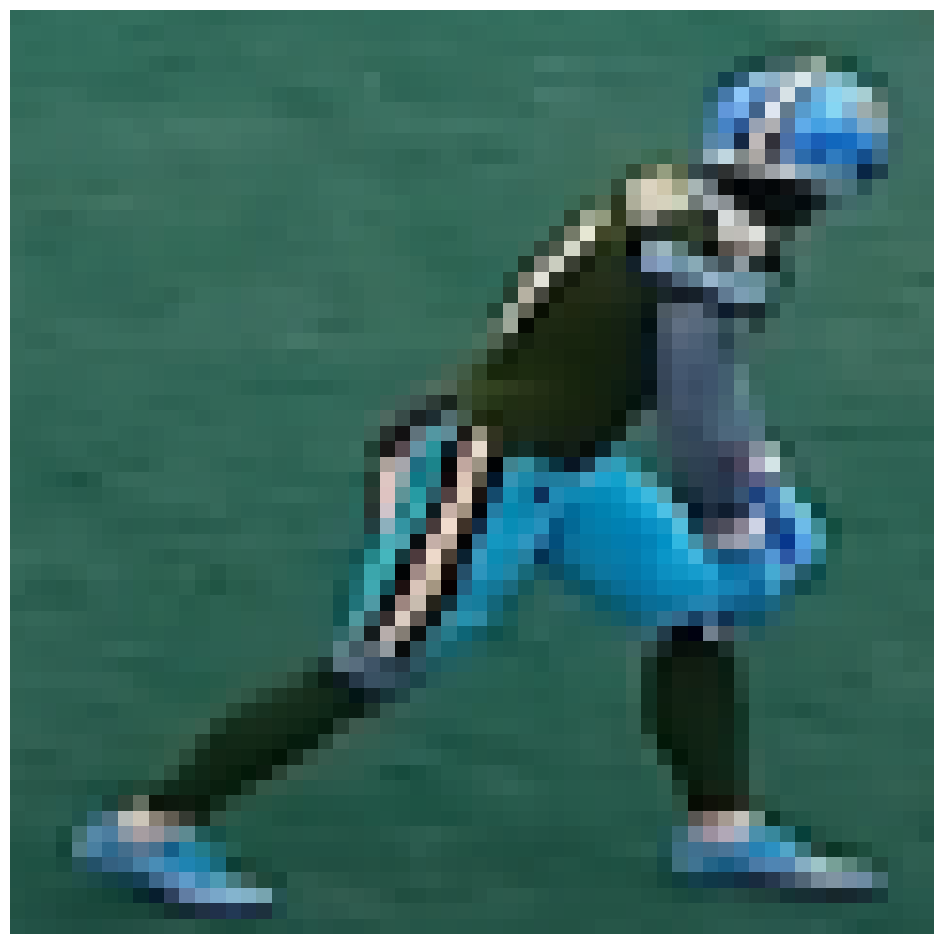

Initializing video processing with YOLO tracking...

0: 384x640 (no detections), 51.1ms
Speed: 4.6ms preprocess, 51.1ms inference, 38.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.9ms
Speed: 3.8ms preprocess, 10.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.0ms
Speed: 2.7ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 3.1ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no 

In [3]:
team_a_name = "Chicago Bears"
team_b_name = "Green Bay Packers"
year = "2024"
video_path = "/content/drive/MyDrive/NFL/Chicago Bears vs. Green Bay Packers Game Highlights.mp4"

process_video_with_yolo_tracking_optimized(video_path, team_a_name, team_b_name, year)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os

class TeamDataset(Dataset):
    def __init__(self, team_a_dir, team_b_dir):
        self.team_a_files = [os.path.join(team_a_dir, f) for f in os.listdir(team_a_dir)]
        self.team_b_files = [os.path.join(team_b_dir, f) for f in os.listdir(team_b_dir)]
        self.all_files = self.team_a_files + self.team_b_files
        self.labels = [0]*len(self.team_a_files) + [1]*len(self.team_b_files)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        data = np.load(self.all_files[idx]).astype(np.float32)
        label = self.labels[idx]
        return torch.tensor(data), torch.tensor(label)

class TeamClassifier(nn.Module):
    def __init__(self, input_size=11184):
        super(TeamClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),  # Apply batch normalization after the linear layer
            nn.ReLU(),             # Replace sigmoid with ReLU for better performance
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),   # Apply batch normalization before activation
            nn.ReLU(),             # Activation function
            nn.Dropout(0.3),
            nn.Linear(512, 1),
        )
    def forward(self, x):
        return self.classifier(x)

def train_model():
    # Initialize dataset
    dataset = TeamDataset(
        team_a_dir=f"/content/{team_a_name}",
        team_b_dir=f"/content/{team_b_name}"
    )

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TeamClassifier().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    best_val_acc = 0
    for epoch in range(20):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_team_classifier.pth")

    print(f"Training complete. Best validation accuracy: {best_val_acc:.2f}%")



In [ ]:
train_model()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os

def predict_team(image, model_path):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TeamClassifier().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Load and prepare input
    data = np.array(image,dtype=np.float32)
    input_tensor = torch.tensor(data).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probability = torch.sigmoid(output).item()
    if(probability<=0.2):
      return team_a_name,probability
    elif(probability>=0.6):
      return team_b_name,probability
    else:
      return "Unknown",probability


In [7]:
import cv2
import numpy as np
import math
from PIL import Image

def classify_team (crop):
  team_label ,conf =predict_team(crop,"best_team_classifier.pth")
  return team_label
# Smoothing factor for exponential moving average (0 < alpha < 1)
ALPHA = 0.8

class LostTrack:
    def __init__(self, original_id,class_id, team_label, bbox, conf, frame_idx, appearance_feature):
        self.original_id = original_id
        self.class_id=class_id
        self.team_label = team_label
        self.last_bbox = bbox
        self.conf = conf
        self.last_seen = frame_idx
        self.velocity_history = []
        self.appearance_feature = appearance_feature

    def update(self, bbox, frame_idx, appearance_feature):
        # Update with new detection
        x1, y1, x2, y2 = self.last_bbox
        cx_old, cy_old = (x1 + x2)/2, (y1 + y2)/2
        nx1, ny1, nx2, ny2 = bbox
        cx_new, cy_new = (nx1 + nx2)/2, (ny1 + ny2)/2
        dx, dy = cx_new - cx_old, cy_new - cy_old

        self.velocity_history.append((dx, dy))
        if len(self.velocity_history) > 5:
            self.velocity_history.pop(0)

        self.last_bbox = bbox
        self.last_seen = frame_idx
        self.appearance_feature = appearance_feature

    def predict_position(self):
        if self.velocity_history:
            avg_dx = np.mean([v[0] for v in self.velocity_history])
            avg_dy = np.mean([v[1] for v in self.velocity_history])
        else:
            avg_dx, avg_dy = 0, 0

        x1, y1, x2, y2 = self.last_bbox
        return (x1 + avg_dx, y1 + avg_dy, x2 + avg_dx, y2 + avg_dy)

    def get_velocity(self):
        if self.velocity_history:
            return np.mean([v[0] for v in self.velocity_history]), np.mean([v[1] for v in self.velocity_history])
        return 0, 0

def compute_appearance_feature(crop):
    # Implement your feature extraction (e.g., color histogram)
    return cv2.calcHist([crop], [0,1,2], None, [8,8,8], [0,256,0,256,0,256])

def process_video_with_models(source_video_path, team_a_name, team_b_name, year):
    model = YOLO('/content/drive/MyDrive/NFL/best.pt')
    cap = cv2.VideoCapture(source_video_path)
    frame_count = 0
    out = None
    prev_frame = None

    # Key: original_id, Value: (team_label, color, conf, bbox, center, appearance_feature)
    track_info = {}
    # Key: tracker_id, Value: original_id
    track_id_mapping = {}
    # Key: original_id, Value: LostTrack instance
    lost_tracks = {}
    original_id_counter = 1

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        # Scene change detection
        t_frame = np.array(transform(Image.fromarray(frame)))
        if prev_frame is not None and is_scene_change_frame_diff(prev_frame, t_frame):
            track_info.clear()
            track_id_mapping.clear()
            lost_tracks.clear()
            original_id_counter = 1
        prev_frame = t_frame.copy() if t_frame is not None else prev_frame

        frame_count += 1
        results = model.track(frame, conf=0.5, iou=0.5, persist=True, tracker="bytetrack.yaml")
        detected_objects = results[0].boxes.data.cpu().numpy()

        current_detections = {}
        for obj in detected_objects:
            if len(obj) < 7: continue  # Skip invalid detections

            x1, y1, x2, y2, track_id, conf, class_id = map(float, obj[:7])
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            bbox = (x1, y1, x2, y2)
            center = ((x1+x2)/2, (y1+y2)/2)
            tracker_id = int(track_id)
            if class_id==1:
              team_label="Referee"
              color=(0,0,255)
            # Get appearance feature
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0: continue
            t_crop=np.array(transform(Image.fromarray(crop)))
            if(t_crop.dtype!=np.uint8):
              t_crop=(t_crop*255).astype(np.uint8)
            appearance = compute_appearance_feature(t_crop)

            # 1. Check if this tracker ID is already mapped
            if tracker_id in track_id_mapping:
                original_id = track_id_mapping[tracker_id]
                # Update existing track with EMA smoothing
                if original_id in track_info:
                    class_id,team_label, color, stored_conf, prev_bbox, prev_center, _ = track_info[original_id]
                    # Update track info
                    track_info[original_id] = (
                        class_id,team_label, color, conf,
                        bbox, center, appearance
                    )
                    current_detections[original_id] = True
                    continue
                else:
                    del track_id_mapping[tracker_id]
            # 2. Try to match with lost tracks
            best_match = None
            best_score = -np.inf

            for lost_id, lost_track in lost_tracks.items():
                # Motion prediction
                pred_bbox = lost_track.predict_position()
                px1, py1, px2, py2 = pred_bbox
                pred_center = ((px1+px2)/2, (py1+py2)/2)
                # Motion similarity
                dist = np.hypot(center[0]-pred_center[0], center[1]-pred_center[1])
                if dist > 50: continue  # Skip unlikely matches
                # Appearance similarity
                hist_diff = cv2.compareHist(
                    lost_track.appearance_feature,
                    appearance,
                    cv2.HISTCMP_BHATTACHARYYA
                )
                similarity = 1 - hist_diff
                vx, vy = lost_track.get_velocity()
                # Angle of the lost track's velocity vector
                lost_angle = math.atan2(vy, vx)
                # Compute the vector from the predicted center to the current detection center
                d_vector = (center[0] - pred_center[0], center[1] - pred_center[1])
                detection_angle = math.atan2(d_vector[1], d_vector[0])
                # Calculate the absolute difference between angles
                angle_diff = abs(lost_angle - detection_angle)
                # Normalize the angle difference to the range [0, π]
                angle_diff = min(angle_diff, 2 * math.pi - angle_diff)
                # Convert the angle difference to a similarity score between 0 and 1.
                # When angle_diff is 0, similarity = 1; when angle_diff is π, similarity = 0.
                direction_similarity = (math.cos(angle_diff) + 1) / 2

                # ---- Combine the Scores ----
                score = 40*similarity + 20*(0.02 * dist) + 20*direction_similarity
                score=score/80
                if score > best_score:
                    best_score = score
                    best_match = lost_id

            if best_match is not None and best_score > 0.3:
                # Recover lost track
                lost_track = lost_tracks[best_match]
                track_id_mapping[tracker_id] = best_match

                # Update track info with new data
                lost_track.update(bbox, frame_count, appearance)
                if lost_track.team_label == team_b_name :
                  color=(0,255,0)
                elif lost_track.team_label==team_a_name:
                  color=(255,0,0)
                elif lost_track.team_label=="Referee":
                  color=(0,0,255)
                else :
                  color=(0,0,0)
                track_info[best_match] = (
                    lost_track.class_id,
                    lost_track.team_label,
                    color,
                    lost_track.conf,
                    bbox, center, appearance
                )
                del lost_tracks[best_match]
                current_detections[best_match] = True
                continue

            # 3. New detection - assign original ID
            original_id = original_id_counter
            original_id_counter += 1
            track_id_mapping[tracker_id] = original_id

            # Classify team
            if class_id==0:
              re_cop=transform(Image.fromarray(crop))
              crop=np.array(re_cop)
              hist=compute_color_histogram(crop)
              image_c=np.concatenate([hist,crop.flatten()])
              team_label = classify_team(image_c)  # Implement your classification
            else:
              team_label="Referee"
            # Update track info
            if team_label == team_b_name :
              color=(0,255,0)
            elif team_label==team_a_name:
              color=(255,0,0)
            elif team_label=="Referee":
              color=(0,0,255)
            else :
              color=(0,0,0)
            track_info[original_id] = (
                class_id,team_label, color, conf,
                bbox, center, appearance
            )
            current_detections[original_id] = True

        # Update lost tracks
        lost_ids = set(track_info.keys()) - set(current_detections.keys())
        for original_id in lost_ids:
            entry = track_info[original_id]
            lost_tracks[original_id] = LostTrack(
            original_id=original_id,
            class_id=entry[0],
            team_label=entry[1],
            bbox=entry[4],
            conf=entry[3],
            frame_idx=frame_count,
            appearance_feature=entry[6]
             )
            del track_info[original_id]

        # Remove old lost tracks
        lost_tracks = {k:v for k,v in lost_tracks.items()
                      if frame_count - v.last_seen < 60}

        # Draw results
        output_frame = frame.copy()

        for original_id in track_info:
            _,team_label, color, conf, bbox, center, _ = track_info[original_id]
            x1, y1, x2, y2 = bbox
            cv2.rectangle(output_frame, (x1,y1), (x2,y2), color, 2)
            label = f"{team_label} {original_id} {conf:.2f}"
            cv2.putText(output_frame, label, (x1,y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
        if out is None:
            h, w = frame.shape[:2]
            out = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (w,h))
        out.write(output_frame)

    cap.release()
    if out: out.release()

In [ ]:
process_video_with_models(video_path, team_a_name, team_b_name, year)